# This song detector checks to see if there are high frequency oscillations in a recording to figure out if it has song. If there are high frequency oscillations, then it will use an amplitude threshold to check for song near the region of high frequency oscillation.

## Full periodicity pipeline for ONE recording:

### For parameter tuning:

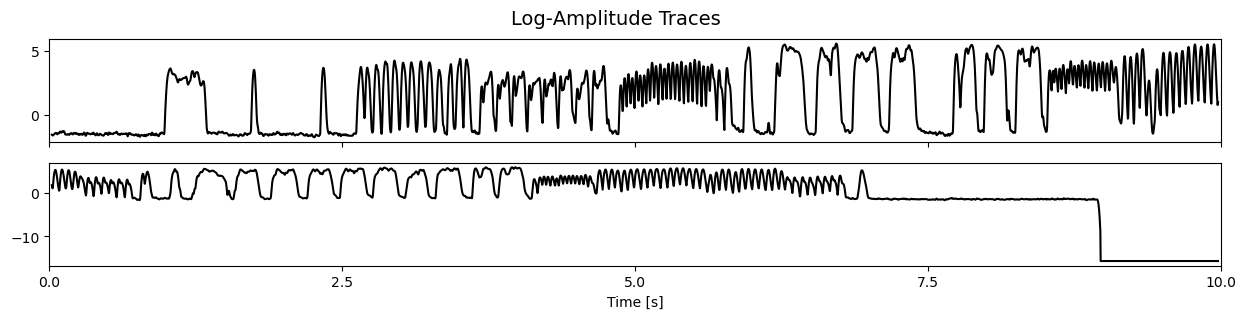

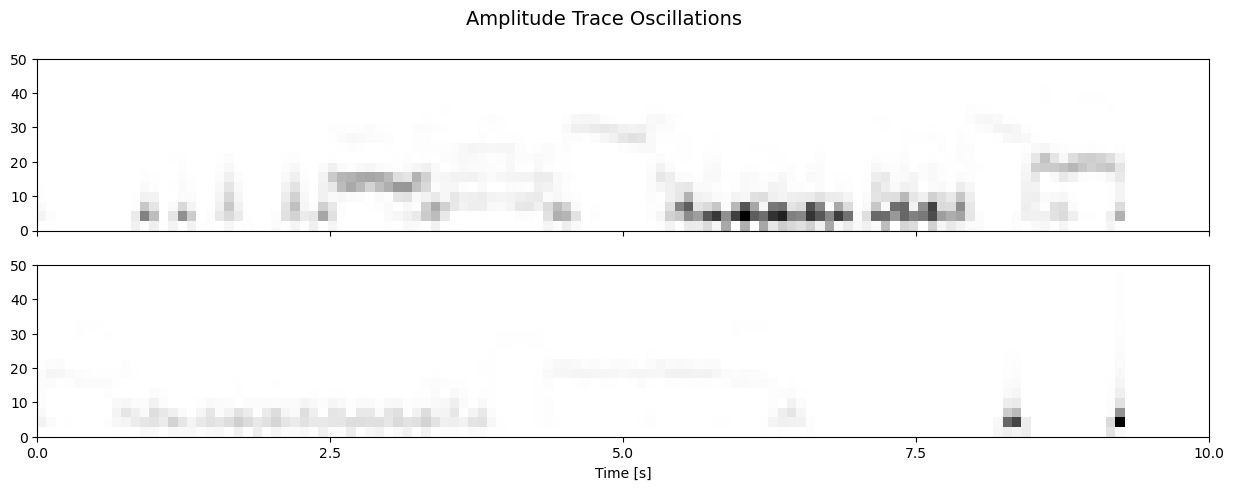

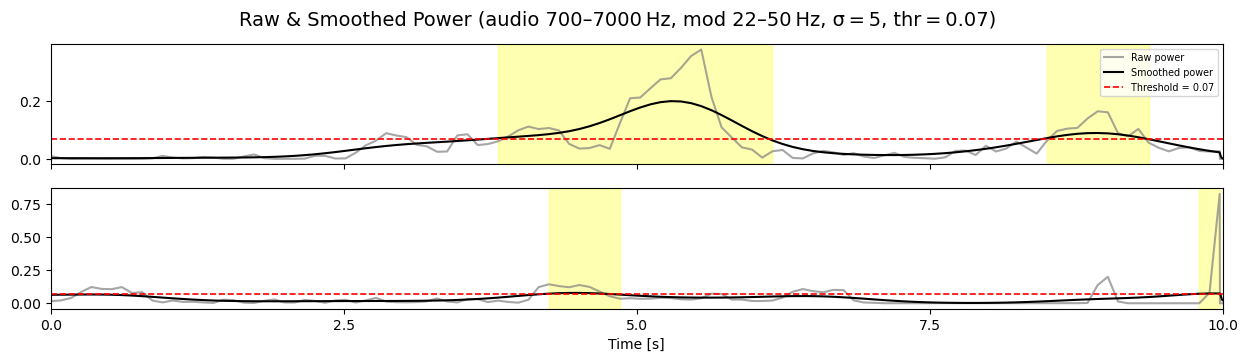

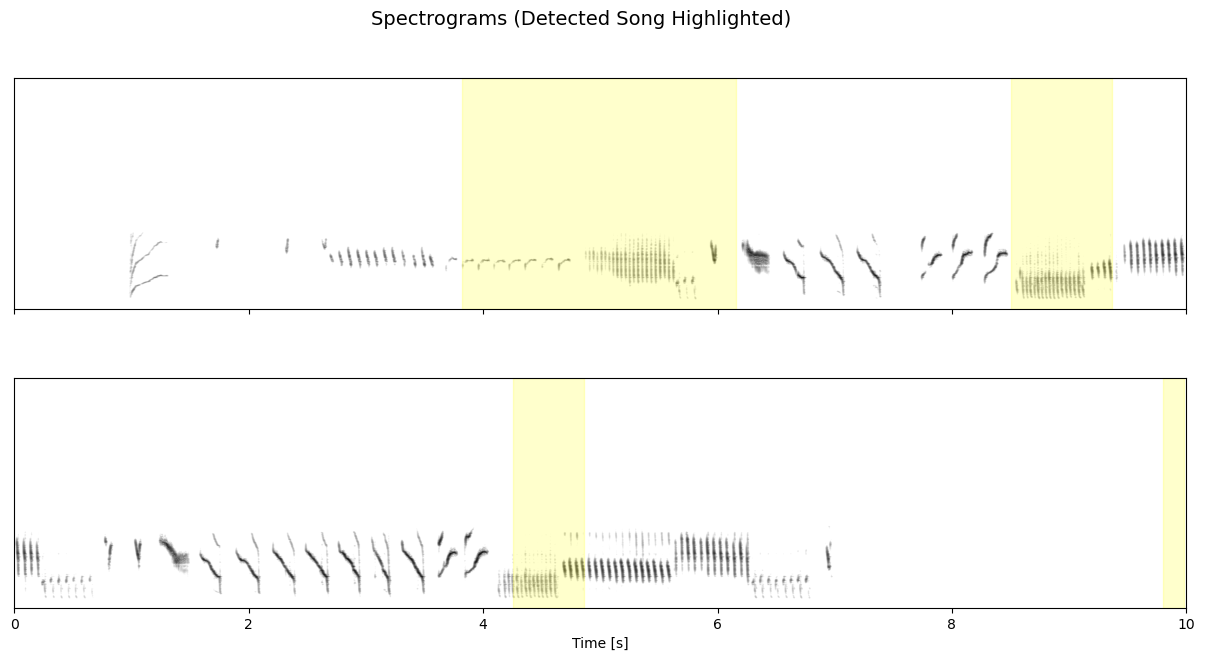

In [1]:
#!/usr/bin/env python
# -*- coding: utf‑8 -*-
"""
Visualise an audio file in stacked panels:
  • log‑amplitude trace
  • amplitude‑envelope modulation spectrogram
  • raw & smoothed modulation‑band power (with detections)
  • full audio spectrogram

User‑tunable parameters:
  ─ segment_duration     – seconds per panel
  ─ low_cut / high_cut   – audio band‑pass (Hz)
  ─ mod_low  / mod_high  – modulation‑frequency band for power (Hz)   <── NEW
  ─ smoothing_sigma      – Gaussian σ for smoothing the power trace
  ─ power_threshold      – detection threshold (same arbitrary units as power)
"""

import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk


# ── Helper: screen size (≈100 dpi) ────────────────────────────────────────────
def get_screen_resolution():
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100


SCREEN_W, SCREEN_H = get_screen_resolution()


# ── Core routine ─────────────────────────────────────────────────────────────
def plot_spectrograms_by_segment(
    file_path: str,
    segment_duration: int = 10,
    low_cut: int = 500,
    high_cut: int = 8000,
    mod_low: int = 5,               # ── NEW ──
    mod_high: int = 50,             # ── NEW ──
    smoothing_sigma: float = 3,
    power_threshold: float = 0.5,
):
    """
    Visualise an audio file in multiple synced panels and highlight sections
    whose smoothed `mod_low–mod_high` Hz modulation power exceeds
    `power_threshold`.

    Raw power  = grey;  Smoothed power = black.
    The power figure is created before (and therefore appears before) the
    spectrogram figure.
    """
    try:
        # 1) Load & band‑pass filter ------------------------------------------------
        sr, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        b, a = ellip(
            5, 0.2, 40,
            [low_cut / (sr / 2), high_cut / (sr / 2)],
            btype="band"
        )
        data = filtfilt(b, a, data)

        # 2) Segment bookkeeping ----------------------------------------------------
        seg_len = segment_duration * sr
        n_segments = int(np.ceil(len(data) / seg_len))

        figs, axs = {}, {}

        # ---- order of creation matters for window stacking -----------------------
        figs["logA"],  axs["logA"]  = plt.subplots(
            n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.3), sharex=True
        )
        figs["amps"],  axs["amps"]  = plt.subplots(
            n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.5), sharex=True
        )
        figs["smooth"], axs["smooth"] = plt.subplots(          # <-- power first
            n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.35), sharex=True
        )
        figs["spec"],  axs["spec"]  = plt.subplots(            # <-- spec second
            n_segments, 1, figsize=(SCREEN_W, SCREEN_H * 0.7), sharex=True
        )
        plt.subplots_adjust(hspace=0.3)

        # Ensure single‑segment cases behave the same
        for key in axs:
            if n_segments == 1:
                axs[key] = [axs[key]]

        # 3) Per‑segment processing -----------------------------------------------
        for i in range(n_segments):
            # ---- slice (zero‑pad last chunk) ------------------------------------
            start, end = i * seg_len, min((i + 1) * seg_len, len(data))
            segment = np.zeros(seg_len, dtype=data.dtype)
            segment[: end - start] = data[start:end]

            # ---- audio spectrogram ---------------------------------------------
            f, t, Sxx = spectrogram(
                segment, fs=sr,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048, noverlap=2048 - 119
            )
            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_norm = (np.clip(Sxx_log, -2, None) - Sxx_log.min()) / (Sxx_log.ptp())

            axs["spec"][i].imshow(
                Sxx_norm, cmap="binary", origin="lower", aspect="auto",
                extent=[0, segment_duration, f.min(), f.max()]
            )
            axs["spec"][i].set_yticks([])
            if i == n_segments - 1:
                axs["spec"][i].set_xlabel("Time [s]")

            # ---- log‑amplitude trace -------------------------------------------
            mask_audio = (f >= low_cut) & (f <= high_cut)
            log_amp = np.log10(np.sum(Sxx[mask_audio, :], axis=0) + np.finfo(float).eps)

            axs["logA"][i].plot(t, log_amp, color="black")
            axs["logA"][i].set_xlim(0, segment_duration)
            if i == n_segments - 1:
                axs["logA"][i].set_xlabel("Time [s]")
                axs["logA"][i].set_xticks(np.linspace(0, segment_duration, 5))
            else:
                axs["logA"][i].set_xticks([])

            # ---- amplitude‑trace spectrogram (padded) ---------------------------
            amp_fs = len(t) / segment_duration
            nper   = 128
            pad    = nper // 2
            padded = np.pad(
                log_amp,
                (pad, pad + int(segment_duration * amp_fs) - len(log_amp)),
                mode="constant"
            )
            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                padded, fs=amp_fs, window="hann", nperseg=nper, noverlap=96
            )
            t_amp = t_amp_raw - pad / amp_fs

            if t_amp[-1] < segment_duration:
                extra = int(np.round((segment_duration - t_amp[-1]) * amp_fs))
                Sxx_amp = np.pad(Sxx_amp, ((0, 0), (0, extra)), mode="constant")
                t_amp = np.concatenate([t_amp, t_amp[-1] + np.arange(1, extra + 1) / amp_fs])

            axs["amps"][i].imshow(
                Sxx_amp, cmap="binary", origin="lower", aspect="auto",
                extent=[0, segment_duration, f_amp.min(), f_amp.max()]
            )
            axs["amps"][i].set_ylim(0, mod_high)                  # updated
            axs["amps"][i].set_xlim(0, segment_duration)
            if i == n_segments - 1:
                axs["amps"][i].set_xlabel("Time [s]")
                axs["amps"][i].set_xticks(np.linspace(0, segment_duration, 5))
            else:
                axs["amps"][i].set_xticks([])

            # ---- modulation‑band power & smoothing -----------------------------
            mod_mask = (f_amp >= mod_low) & (f_amp <= mod_high)   # updated
            raw_pow  = np.sum(Sxx_amp[mod_mask, :], axis=0)
            smooth   = gaussian_filter1d(raw_pow, sigma=smoothing_sigma)

            # ---- combined power panel ------------------------------------------
            ax_p = axs["smooth"][i]
            ax_p.plot(t_amp, raw_pow,   color="grey",  alpha=0.7, label="Raw power")
            ax_p.plot(t_amp, smooth,    color="black",            label="Smoothed power")
            ax_p.axhline(power_threshold, color="red", ls="--", lw=1.2,
                         label=f"Threshold = {power_threshold}")
            ax_p.set_xlim(0, segment_duration)

            # Highlight detections
            detect = smooth > power_threshold
            if detect.any():
                in_span = False
                for j, flag in enumerate(detect):
                    if flag and not in_span:
                        in_span, t_start = True, t_amp[j]
                    elif not flag and in_span:
                        ax_p.axvspan(t_start, t_amp[j], color="yellow", alpha=0.3)
                        axs["spec"][i].axvspan(t_start, t_amp[j], color="yellow", alpha=0.2)
                        in_span = False
                if in_span:
                    ax_p.axvspan(t_start, segment_duration, color="yellow", alpha=0.3)
                    axs["spec"][i].axvspan(t_start, segment_duration, color="yellow", alpha=0.2)

            if i == n_segments - 1:
                ax_p.set_xlabel("Time [s]")
                ax_p.set_xticks(np.linspace(0, segment_duration, 5))
            else:
                ax_p.set_xticks([])

            if i == 0:
                ax_p.legend(fontsize="x-small", loc="upper right")

        # 4) Figure titles --------------------------------------------------------
        figs["logA"].suptitle("Log‑Amplitude Traces", fontsize=14)
        figs["amps"].suptitle("Amplitude Trace Oscillations", fontsize=14)
        figs["smooth"].suptitle(
            f"Raw & Smoothed Power (audio {low_cut}–{high_cut} Hz, "
            f"mod {mod_low}–{mod_high} Hz, σ = {smoothing_sigma}, thr = {power_threshold})",
            fontsize=14
        )
        figs["spec"].suptitle("Spectrograms (Detected Song Highlighted)", fontsize=14)

        plt.show()

    except (OSError, ValueError) as err:
        print(f"Error processing {file_path}: {err}")


# ── Example usage ────────────────────────────────────────────────────────────
if __name__ == "__main__":
    FILE_PATH = (
     "/Volumes/my_own_SSD/UO_stuff/nerve_transections/USA5207/5/USA5207_45098.67569289_6_21_18_46_9.wav"
    )

    plot_spectrograms_by_segment(
        FILE_PATH,
        segment_duration=10,
        low_cut=700,
        high_cut=7000,
        mod_low=22,          # <── NEW: modulation band lower edge
        mod_high=50,         # <── NEW: modulation band upper edge
        smoothing_sigma=5,
        power_threshold=0.07,
    )


### For generating the .json file of detected songs:

In [2]:
#!/usr/bin/env python
# -*- coding: utf‑8 -*-

import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import os
import json


# ── Core detector ────────────────────────────────────────────────────────────
def detect_song_intervals(
    file_path,
    segment_duration=10,
    low_cut=500,
    high_cut=8000,
    low_mod=10,              # ── NEW ──
    high_mod=40,             # ── NEW ──
    smoothing_sigma=3,
    power_threshold=0.5,
):
    """
    Detects [start_sec, end_sec] intervals where the smoothed `low_mod–high_mod`
    Hz modulation power of the log‑amplitude trace exceeds `power_threshold`.
    """
    try:
        sr, data = wavfile.read(file_path)
        if data.ndim > 1:                    # stereo → mono
            data = data.mean(axis=1)

        # Band‑pass filter raw audio
        nyq = sr / 2
        b, a = ellip(5, 0.2, 40, [low_cut / nyq, high_cut / nyq], btype="band")
        data = filtfilt(b, a, data)

        seg_len_samples = int(segment_duration * sr)
        n_segments = int(np.ceil(len(data) / seg_len_samples))
        detected_intervals = []

        for i in range(n_segments):
            start_samp = i * seg_len_samples
            end_samp   = min(start_samp + seg_len_samples, len(data))
            segment = np.zeros(seg_len_samples, dtype=data.dtype)
            segment[: end_samp - start_samp] = data[start_samp:end_samp]

            # ── Audio‑spectrogram of segment ──────────────────────────────
            f, t, Sxx = spectrogram(
                segment,
                fs=sr,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119,
            )

            # Log‑amplitude trace
            mask_audio_band = (f >= low_cut) & (f <= high_cut)
            amp_trace = np.sum(Sxx[mask_audio_band, :], axis=0)
            log_amp = np.log10(amp_trace + np.finfo(float).eps)

            # ── Spectrogram of amplitude trace (with full‑duration padding)
            amp_fs   = len(t) / segment_duration
            nper     = 128
            pad      = nper // 2
            exp_len  = int(segment_duration * amp_fs)

            log_amp_padded = np.pad(
                log_amp,
                (pad, pad + exp_len - len(log_amp)),
                mode="constant",
            )

            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                log_amp_padded, fs=amp_fs, window="hann", nperseg=nper, noverlap=96
            )
            t_amp = t_amp_raw - pad / amp_fs

            # ── Ensure full‑width spectrogram ─────────────────────────────
            if t_amp[-1] < segment_duration:
                extra_cols = int(np.round((segment_duration - t_amp[-1]) * amp_fs))
                if extra_cols > 0:
                    Sxx_amp = np.pad(Sxx_amp, ((0, 0), (0, extra_cols)), mode="constant")
                    t_extra = t_amp[-1] + np.arange(1, extra_cols + 1) / amp_fs
                    t_amp   = np.concatenate((t_amp, t_extra))

            # ── Modulation‑band power envelope ───────────────────────────
            mask_mod_band = (f_amp >= low_mod) & (f_amp <= high_mod)  # NEW
            band_power    = np.sum(Sxx_amp[mask_mod_band, :], axis=0)
            smooth_pow    = gaussian_filter1d(band_power, sigma=smoothing_sigma)

            # ── Threshold‑based interval extraction ───────────────────────
            above = smooth_pow > power_threshold
            in_span = False
            for j, flg in enumerate(above):
                cur_time = i * segment_duration + t_amp[j]
                if flg and not in_span:
                    in_span  = True
                    span_start = cur_time
                elif not flg and in_span:
                    detected_intervals.append([span_start, cur_time])
                    in_span = False
            if in_span:  # ran off end of panel still above threshold
                detected_intervals.append([span_start, (i + 1) * segment_duration])

        return detected_intervals

    except Exception as err:
        print(f"⚠️  Error processing {file_path}: {err}")
        return []


# ── Folder‑level helper ───────────────────────────────────────────────────────
def process_folder(folder_path, output_json_path, **kwargs):
    results = {}
    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith(".wav"):
            fpath = os.path.join(folder_path, fname)
            print(f"Processing: {fname}")
            results[fname] = detect_song_intervals(fpath, **kwargs)

    with open(output_json_path, "w") as fp:
        json.dump(results, fp, indent=4)

    print(f"\nSaved song detection results to: {output_json_path}")


# ── Example usage ─────────────────────────────────────────────────────────────
if __name__ == "__main__":
    FOLDER = (
        "/Volumes/my_own_SSD/UO_stuff/nerve_transections/USA5207/38"
    )
    OUT_JSON = FOLDER + "_periodicity_only_detected_song_intervals.json"

    process_folder(
        FOLDER,
        OUT_JSON,
        segment_duration=10,
        low_cut=700,
        high_cut=7000,
        low_mod=22,            # ← choose your modulation band here
        high_mod=55,          # ←
        smoothing_sigma=5,
        power_threshold=0.05,
    )

Processing: USA5207_45131.21076917_7_24_5_51_16.wav
Processing: USA5207_45131.21908073_7_24_6_5_8.wav
Processing: USA5207_45131.22261780_7_24_6_11_1.wav
Processing: USA5207_45131.22732034_7_24_6_18_52.wav
Processing: USA5207_45131.23292741_7_24_6_28_12.wav
Processing: USA5207_45131.23617472_7_24_6_33_37.wav
Processing: USA5207_45131.23635432_7_24_6_33_55.wav
Processing: USA5207_45131.23662746_7_24_6_34_22.wav
Processing: USA5207_45131.23667722_7_24_6_34_27.wav
Processing: USA5207_45131.23681133_7_24_6_34_41.wav
Processing: USA5207_45131.23705125_7_24_6_35_5.wav
Processing: USA5207_45131.23708313_7_24_6_35_8.wav
Processing: USA5207_45131.23719213_7_24_6_35_19.wav
Processing: USA5207_45131.23735374_7_24_6_35_35.wav
Processing: USA5207_45131.23737944_7_24_6_35_37.wav
Processing: USA5207_45131.23749092_7_24_6_35_49.wav
Processing: USA5207_45131.23755592_7_24_6_35_55.wav
Processing: USA5207_45131.23761194_7_24_6_36_1.wav
Processing: USA5207_45131.23808443_7_24_6_36_48.wav
Processing: USA520

## Editing to save a .json file with the periodicty and amplitude values:

In [3]:
#!/usr/bin/env python
# -*- coding: utf‑8 -*-

import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import os
import json

def detect_song_intervals(
    file_path,
    segment_duration=10,
    low_cut=500,
    high_cut=8000,
    low_mod=10,
    high_mod=40,
    smoothing_sigma=3,
    power_threshold=0.5,
):
    """
    Returns a dict with:
      - 'intervals': list of [start_sec, end_sec]
      - 'times':    list of time stamps for each power sample
      - 'raw_power':      list of unsmoothed modulation‐band power
      - 'smoothed_power': list of smoothed power
      - 'threshold':      the power_threshold used
    """
    # prepare accumulators
    all_intervals = []
    all_times = []
    all_raw   = []
    all_smooth = []

    try:
        sr, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # bandpass filter
        nyq = sr / 2
        b, a = ellip(5, 0.2, 40,
                     [low_cut/nyq, high_cut/nyq],
                     btype="band")
        data = filtfilt(b, a, data)

        seg_len_samps = int(segment_duration * sr)
        n_segments    = int(np.ceil(len(data) / seg_len_samps))

        # process each fixed‐length segment
        for i in range(n_segments):
            start_idx = i * seg_len_samps
            end_idx   = min(start_idx + seg_len_samps, len(data))
            seg = np.zeros(seg_len_samps, dtype=data.dtype)
            seg[: end_idx - start_idx] = data[start_idx:end_idx]

            # 1) audio spectrogram → log‐amp trace
            f, t, Sxx = spectrogram(
                seg,
                fs=sr,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=2048-119,
            )
            mask_audio = (f >= low_cut) & (f <= high_cut)
            amp_trace  = Sxx[mask_audio, :].sum(axis=0)
            log_amp    = np.log10(amp_trace + np.finfo(float).eps)

            # 2) modulation spectrogram of the log‐amp trace
            amp_fs    = len(t) / segment_duration
            nper      = 128
            pad       = nper // 2
            exp_len   = int(segment_duration * amp_fs)
            padded    = np.pad(
                log_amp,
                (pad, pad + exp_len - len(log_amp)),
                mode="constant"
            )
            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                padded,
                fs=amp_fs,
                window="hann",
                nperseg=nper,
                noverlap=96
            )
            t_amp = t_amp_raw - pad / amp_fs

            # ensure full-duration coverage
            if t_amp[-1] < segment_duration:
                extra = int(np.round((segment_duration - t_amp[-1])*amp_fs))
                Sxx_amp = np.pad(Sxx_amp, ((0,0),(0,extra)), mode="constant")
                t_amp   = np.concatenate([t_amp,
                                          t_amp[-1] + np.arange(1,extra+1)/amp_fs])

            # 3) extract and smooth the modulation‐band power
            mask_mod    = (f_amp >= low_mod) & (f_amp <= high_mod)
            band_power  = Sxx_amp[mask_mod, :].sum(axis=0)
            smooth_pow  = gaussian_filter1d(band_power, sigma=smoothing_sigma)

            # accumulate absolute time & power series
            abs_time = i*segment_duration + t_amp
            all_times.extend(abs_time.tolist())
            all_raw.extend(band_power.tolist())
            all_smooth.extend(smooth_pow.tolist())

            # 4) threshold detection per segment
            above = smooth_pow > power_threshold
            in_span = False
            for j, flag in enumerate(above):
                ct = abs_time[j]
                if flag and not in_span:
                    in_span  = True
                    span_start = ct
                elif not flag and in_span:
                    all_intervals.append([span_start, ct])
                    in_span = False
            if in_span:
                all_intervals.append([span_start, (i+1)*segment_duration])

        # return full dict
        return {
            "intervals": all_intervals,
            "times": all_times,
            "raw_power": all_raw,
            "smoothed_power": all_smooth,
            "threshold": power_threshold
        }

    except Exception as e:
        print(f"⚠️ Error processing {file_path}: {e}")
        return {
            "intervals": [],
            "times": [],
            "raw_power": [],
            "smoothed_power": [],
            "threshold": power_threshold
        }


def process_folder(folder_path, output_json_path, **kwargs):
    results = {}
    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith(".wav"):
            path = os.path.join(folder_path, fname)
            print(f"Processing: {fname}")
            results[fname] = detect_song_intervals(path, **kwargs)

    # write everything into one JSON
    with open(output_json_path, "w") as fp:
        json.dump(results, fp, indent=4)

    print(f"\nSaved detection + power data to: {output_json_path}")


if __name__ == "__main__":
    FOLDER = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_testing_pipeline"
    OUT_JSON = FOLDER + "_detailed_periodicity_song_intervals.json"

    process_folder(
        FOLDER,
        OUT_JSON,
        segment_duration=10,
        low_cut=700,
        high_cut=7000,
        low_mod=22,
        high_mod=55,
        smoothing_sigma=5,
        power_threshold=0.05,
    )


Processing: USA5288_45390.29509926_4_8_8_11_49.wav
Processing: USA5288_45390.52497071_4_8_14_34_57.wav

Saved detection + power data to: /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_testing_pipeline_detailed_periodicity_song_intervals.json


## Full amplitude pipeline for ONE song for parameter tuning:

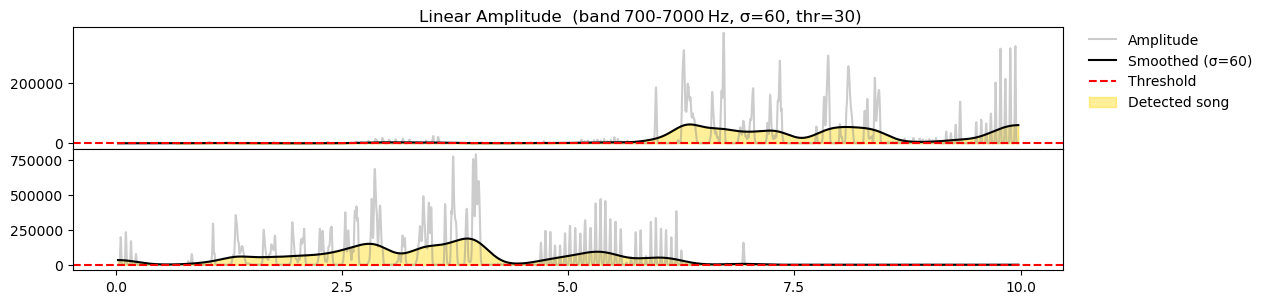

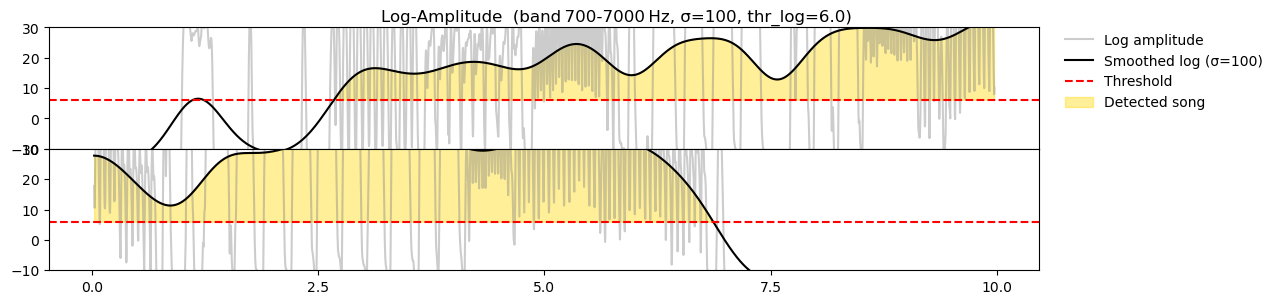

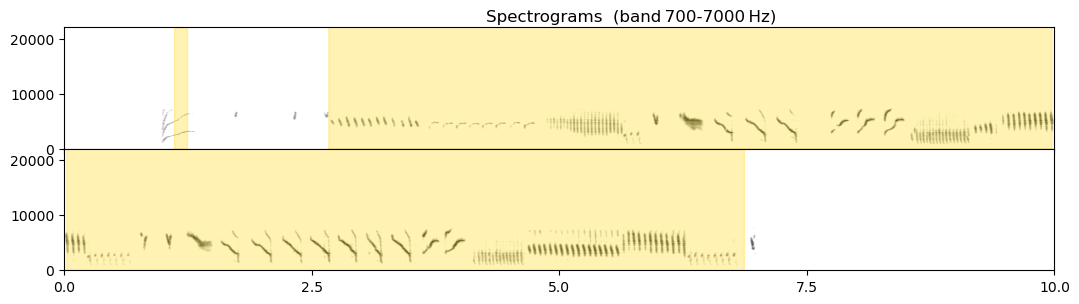


Detected song intervals (s):
      1.11 –     1.24
      2.67 –     9.97
     10.02 –    16.87


In [4]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ------------------------------------------------------------
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100

width_inches, height_inches = get_screen_resolution()

# ------------------------------------------------------------
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:
            intervals.append((start, times[idx] + t_offset));  in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05,
        sigma_log: Optional[float] = None,
        threshold_log: Optional[float] = None,
        log_base: float = 10
    ) -> List[Tuple[float, float]]:

    if sigma_log is None:
        sigma_log = sigma
    eps = np.finfo(float).eps

    # ---------- Load & band‑pass filter ----------
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ---------- Segment bookkeeping ----------
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ---------- Figure stacks (no vertical spacing) ----------
    fig1, axs_lin = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig2, axs_log = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    fig3, axs_spc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={"hspace": 0})
    if n_seg == 1:
        axs_lin, axs_log, axs_spc = [axs_lin], [axs_log], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # ---------- Per‑segment processing ----------
    for i in range(n_seg):
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        # Spectrogram
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # Linear & log amplitude
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp   = np.sum(Sxx[rows, :], axis=0)
        amp_s = gaussian_filter1d(amp, sigma=sigma)
        mask_lin = amp_s > threshold

        amp_log = 10 * np.log10(amp + eps) if log_base == 10 else np.log(amp + eps)
        amp_log_s = gaussian_filter1d(amp_log, sigma=sigma_log)
        if threshold_log is None and i == 0:
            threshold_log = np.percentile(amp_log_s, 90)
        mask_log = amp_log_s > threshold_log

        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        # ---- Linear amplitude plot ----
        axL = axs_lin[i]
        axL.plot(t, amp, color='gray', alpha=0.4,
                 label='Amplitude' if i == 0 else None)
        axL.plot(t, amp_s, color='black',
                 label=f'Smoothed (σ={sigma})' if i == 0 else None)
        axL.axhline(threshold, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axL.fill_between(t, amp_s, threshold, where=mask_lin,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), borderaxespad=0, frameon=False)

        # ---- Log amplitude plot ----
        axLg = axs_log[i]
        axLg.plot(t, amp_log, color='gray', alpha=0.4,
                  label='Log amplitude' if i == 0 else None)
        axLg.plot(t, amp_log_s, color='black',
                  label=f'Smoothed log (σ={sigma_log})' if i == 0 else None)
        axLg.axhline(threshold_log, color='red', ls='--',
                     label='Threshold' if i == 0 else None)
        axLg.fill_between(t, amp_log_s, threshold_log, where=mask_log,
                          color='gold', alpha=0.4,
                          label='Detected song' if i == 0 else None)
        axLg.set_ylim(-10, 30)
        axLg.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=10, loc='upper left',
                        bbox_to_anchor=(1.02, 1.0), borderaxespad=0, frameon=False)

        # ---- Spectrogram plot ----
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log, color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

    # ---------- Titles & final layout ----------
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude  (band {bp}, σ={sigma}, thr={threshold})', fontsize=12)
    fig2.suptitle(f'Log‑Amplitude  (band {bp}, σ={sigma_log}, thr_log={threshold_log:.1f})',
                  fontsize=12)
    fig3.suptitle(f'Spectrograms  (band {bp})', fontsize=12)
    for fig in (fig1, fig2, fig3):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.78)  # room for legends

    plt.show()

    # ---------- Console output ----------
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ------------------------------------------------------------
if __name__ == "__main__":
    wav_path = Path(
        "/Volumes/my_own_SSD/UO_stuff/nerve_transections/USA5207/5/USA5207_45098.67569289_6_21_18_46_9.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=60,
            threshold=30,
            sigma_log=100,
            threshold_log=6     # dB
        )
    else:
        print("Example WAV not found:", wav_path)


### Generate the .json file:

In [5]:
#!/usr/bin/env python
"""
Batch long‑amplitude song detector + envelope export
----------------------------------------------------
Point this at a directory full of .wav files and it will create
<folder_name>_longamp_detected_song_intervals.json
with, for each file:
{
  "example.wav": {
      "times":               [...],
      "log_amplitude":       [...],
      "smoothed_log_amplitude": [...],
      "threshold":           6.0,
      "intervals":           [ [start, end], ... ]
  },
  ...
}
"""
from __future__ import annotations

import json
import numpy as np
from pathlib import Path
from typing import List, Tuple, Dict, Union

from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d


# --------------------------------------------------------------------
def mask_to_intervals(
    mask: np.ndarray,
    times: np.ndarray,
    t_offset: float,
) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        t = times[idx] + t_offset
        if v and not in_run:
            in_run, start = True, t
        elif not v and in_run:
            intervals.append((start, t))
            in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals


# --------------------------------------------------------------------
def detect_song_intervals_longamp(
    file_path: Union[str, Path],
    *,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: float | None = 6.0,
    log_base: float = 10,
) -> Dict[str, object]:
    """
    Analyze the file in fixed‐length chunks, compute the log‐amplitude
    envelope and smoothed envelope, threshold it, and detect intervals.
    Returns a dict with:
      - 'times':               [t0, t1, ...]
      - 'log_amplitude':       [L0, L1, ...]
      - 'smoothed_log_amplitude': [S0, S1, ...]
      - 'threshold':           float
      - 'intervals':           [ [start, end], ... ]
    """
    file_path = Path(file_path)
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)

    # band‑pass filter
    nyq = sr / 2
    wp = [bandpass_filter_low_cut/nyq, bandpass_filter_high_cut/nyq]
    b, a = ellip(5, 0.2, 40, wp, btype="band")
    data = filtfilt(b, a, data)

    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))
    eps     = np.finfo(float).eps

    # accumulators
    all_times:      List[float] = []
    all_log_amp:    List[float] = []
    all_log_amp_s:  List[float] = []
    all_intervals:  List[Tuple[float, float]] = []

    # process each segment
    for i in range(n_seg):
        start_idx = i*seg_len
        end_idx   = min(start_idx+seg_len, len(data))
        seg = np.zeros(seg_len, dtype=float)
        seg[: end_idx-start_idx] = data[start_idx:end_idx]

        # 1) compute audio spectrogram & envelope
        f, t, Sxx = spectrogram(
            seg,
            fs=sr,
            window=windows.gaussian(2048, 2048/8),
            nperseg=2048,
            noverlap=2048-119,
        )
        mask_band = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp       = Sxx[mask_band, :].sum(axis=0)

        # 2) log envelope
        if log_base == 10:
            amp_log = 10 * np.log10(amp + eps)
        else:
            amp_log = np.log(amp + eps)

        # 3) smooth log envelope
        amp_log_s = gaussian_filter1d(amp_log, sigma=sigma_log)

        # 4) set threshold on first segment if needed
        if threshold_log is None and i == 0:
            threshold_log = float(np.percentile(amp_log_s, 90))

        # 5) record times & values (absolute)
        abs_t = t + i*segment_duration
        all_times.extend(abs_t.tolist())
        all_log_amp.extend(amp_log.tolist())
        all_log_amp_s.extend(amp_log_s.tolist())

        # 6) detect intervals
        mask = amp_log_s > threshold_log  # type: ignore
        seg_intervals = mask_to_intervals(mask, t, i*segment_duration)
        all_intervals.extend(seg_intervals)

    return {
        "times":                  all_times,
        "log_amplitude":          all_log_amp,
        "smoothed_log_amplitude": all_log_amp_s,
        "threshold":              threshold_log,  # type: ignore
        "intervals":              all_intervals
    }


# --------------------------------------------------------------------
def process_folder(
    folder_path: Union[str, Path],
    *,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: float | None = 6.0,
    log_base: float = 10,
    overwrite: bool = True,
) -> Path:
    folder_path = Path(folder_path).expanduser().resolve()
    assert folder_path.is_dir(), f"{folder_path} is not a directory"

    json_path = folder_path.with_suffix("").parent / f"{folder_path.name}_detailed_logamp_detected_song_intervals.json"
    if json_path.exists() and not overwrite:
        raise FileExistsError(f"{json_path} already exists")

    wav_files = sorted(folder_path.glob("*.wav"))
    print(f"📂 Processing {len(wav_files)} files in {folder_path}")

    results: Dict[str, object] = {}
    for wav in wav_files:
        print(f"⏳ {wav.name}")
        results[wav.name] = detect_song_intervals_longamp(
            wav,
            segment_duration=segment_duration,
            bandpass_filter_low_cut=bandpass_filter_low_cut,
            bandpass_filter_high_cut=bandpass_filter_high_cut,
            sigma_log=sigma_log,
            threshold_log=threshold_log,
            log_base=log_base,
        )

    with open(json_path, "w") as fp:
        json.dump(results, fp, indent=4)

    print(f"✅ Saved results to {json_path}")
    return json_path


# --------------------------------------------------------------------
if __name__ == "__main__":
    folder = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_testing_pipeline"
    process_folder(
        folder,
        segment_duration=10,
        bandpass_filter_low_cut=700,
        bandpass_filter_high_cut=7000,
        sigma_log=100,
        threshold_log=5,  # dB above floor
        log_base=10,
    )


📂 Processing 2 files in /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_testing_pipeline
⏳ USA5288_45390.29509926_4_8_8_11_49.wav
⏳ USA5288_45390.52497071_4_8_14_34_57.wav
✅ Saved results to /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_testing_pipeline_detailed_logamp_detected_song_intervals.json


## Generate a .json file with the amplitude values for graphing (as well as the time segments)

In [ ]:
#!/usr/bin/env python
"""
Batch long‑amplitude song detector + envelope export
----------------------------------------------------
Point this at a directory full of .wav files and it will create
<folder_name>_longamp_detected_song_intervals.json
with, for each file:
{
  "example.wav": {
      "times":               [...],
      "log_amplitude":       [...],
      "smoothed_log_amplitude": [...],
      "threshold":           6.0,
      "intervals":           [ [start, end], ... ]
  },
  ...
}
"""
from __future__ import annotations

import json
import numpy as np
from pathlib import Path
from typing import List, Tuple, Dict, Union

from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d


# --------------------------------------------------------------------
def mask_to_intervals(
    mask: np.ndarray,
    times: np.ndarray,
    t_offset: float,
) -> List[Tuple[float, float]]:
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        t = times[idx] + t_offset
        if v and not in_run:
            in_run, start = True, t
        elif not v and in_run:
            intervals.append((start, t))
            in_run = False
    if in_run:
        intervals.append((start, times[-1] + t_offset))
    return intervals


# --------------------------------------------------------------------
def detect_song_intervals_longamp(
    file_path: Union[str, Path],
    *,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: float | None = 6.0,
    log_base: float = 10,
) -> Dict[str, object]:
    """
    Analyze the file in fixed‐length chunks, compute the log‐amplitude
    envelope and smoothed envelope, threshold it, and detect intervals.
    Returns a dict with:
      - 'times':               [t0, t1, ...]
      - 'log_amplitude':       [L0, L1, ...]
      - 'smoothed_log_amplitude': [S0, S1, ...]
      - 'threshold':           float
      - 'intervals':           [ [start, end], ... ]
    """
    file_path = Path(file_path)
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:
        data = data.mean(axis=1)

    # band‑pass filter
    nyq = sr / 2
    wp = [bandpass_filter_low_cut/nyq, bandpass_filter_high_cut/nyq]
    b, a = ellip(5, 0.2, 40, wp, btype="band")
    data = filtfilt(b, a, data)

    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))
    eps     = np.finfo(float).eps

    # accumulators
    all_times:      List[float] = []
    all_log_amp:    List[float] = []
    all_log_amp_s:  List[float] = []
    all_intervals:  List[Tuple[float, float]] = []

    # process each segment
    for i in range(n_seg):
        start_idx = i*seg_len
        end_idx   = min(start_idx+seg_len, len(data))
        seg = np.zeros(seg_len, dtype=float)
        seg[: end_idx-start_idx] = data[start_idx:end_idx]

        # 1) compute audio spectrogram & envelope
        f, t, Sxx = spectrogram(
            seg,
            fs=sr,
            window=windows.gaussian(2048, 2048/8),
            nperseg=2048,
            noverlap=2048-119,
        )
        mask_band = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp       = Sxx[mask_band, :].sum(axis=0)

        # 2) log envelope
        if log_base == 10:
            amp_log = 10 * np.log10(amp + eps)
        else:
            amp_log = np.log(amp + eps)

        # 3) smooth log envelope
        amp_log_s = gaussian_filter1d(amp_log, sigma=sigma_log)

        # 4) set threshold on first segment if needed
        if threshold_log is None and i == 0:
            threshold_log = float(np.percentile(amp_log_s, 90))

        # 5) record times & values (absolute)
        abs_t = t + i*segment_duration
        all_times.extend(abs_t.tolist())
        all_log_amp.extend(amp_log.tolist())
        all_log_amp_s.extend(amp_log_s.tolist())

        # 6) detect intervals
        mask = amp_log_s > threshold_log  # type: ignore
        seg_intervals = mask_to_intervals(mask, t, i*segment_duration)
        all_intervals.extend(seg_intervals)

    return {
        "times":                  all_times,
        "log_amplitude":          all_log_amp,
        "smoothed_log_amplitude": all_log_amp_s,
        "threshold":              threshold_log,  # type: ignore
        "intervals":              all_intervals
    }


# --------------------------------------------------------------------
def process_folder(
    folder_path: Union[str, Path],
    *,
    segment_duration: float = 10,
    bandpass_filter_low_cut: float = 500,
    bandpass_filter_high_cut: float = 8000,
    sigma_log: float = 100,
    threshold_log: float | None = 6.0,
    log_base: float = 10,
    overwrite: bool = True,
) -> Path:
    folder_path = Path(folder_path).expanduser().resolve()
    assert folder_path.is_dir(), f"{folder_path} is not a directory"

    json_path = folder_path.with_suffix("").parent / f"{folder_path.name}_longamp_detected_song_intervals.json"
    if json_path.exists() and not overwrite:
        raise FileExistsError(f"{json_path} already exists")

    wav_files = sorted(folder_path.glob("*.wav"))
    print(f"📂 Processing {len(wav_files)} files in {folder_path}")

    results: Dict[str, object] = {}
    for wav in wav_files:
        print(f"⏳ {wav.name}")
        results[wav.name] = detect_song_intervals_longamp(
            wav,
            segment_duration=segment_duration,
            bandpass_filter_low_cut=bandpass_filter_low_cut,
            bandpass_filter_high_cut=bandpass_filter_high_cut,
            sigma_log=sigma_log,
            threshold_log=threshold_log,
            log_base=log_base,
        )

    with open(json_path, "w") as fp:
        json.dump(results, fp, indent=4)

    print(f"✅ Saved results to {json_path}")
    return json_path


# --------------------------------------------------------------------
if __name__ == "__main__":
    folder = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_testing_pipeline"
    process_folder(
        folder,
        segment_duration=10,
        bandpass_filter_low_cut=700,
        bandpass_filter_high_cut=7000,
        sigma_log=100,
        threshold_log=5,  # dB above floor
        log_base=10,
    )


📂 Processing 2 files in /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_testing_pipeline
⏳ USA5288_45390.29509926_4_8_8_11_49.wav
⏳ USA5288_45390.52497071_4_8_14_34_57.wav
✅ Saved results to /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_testing_pipeline_longamp_detected_song_intervals.json


: 

# Combine the outputs from the .json files:

In [ ]:
# import json
# from pathlib import Path

# # === User Configuration ===
# # Set these two paths to your JSON files before running the script:
# PERIODICITY_JSON_PATH = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_testing_pipeline_periodicity_only_detected_song_intervals.json")
# AMPLITUDE_THRESHOLD_JSON_PATH = Path("/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_testing_pipeline_logamp_detected_song_intervals.json")

# def load_json(path: Path) -> dict:
#     """
#     Validate that `path` exists and load its JSON content.
#     """
#     if not path.is_file():
#         raise FileNotFoundError(f"No file found at: {path}")
#     with path.open('r') as f:
#         return json.load(f)

# def main():
#     print("Loading detected‐song segments from JSON files...\n")

#     # Load periodicity‐based detection results
#     periodicity_segments = load_json(PERIODICITY_JSON_PATH)
#     print(f"• Loaded {len(periodicity_segments)} entries from:\n  {PERIODICITY_JSON_PATH}")

#     # Load amplitude‐threshold detection results
#     amplitude_threshold_segments = load_json(AMPLITUDE_THRESHOLD_JSON_PATH)
#     print(f"• Loaded {len(amplitude_threshold_segments)} entries from:\n  {AMPLITUDE_THRESHOLD_JSON_PATH}")

#     # Your data are now in:
#     #   periodicity_segments
#     #   amplitude_threshold_segments
#     return periodicity_segments, amplitude_threshold_segments

# if __name__ == "__main__":
#     periodicity_segments, amplitude_threshold_segments = main()


In [ ]:
# import json
# from pathlib import Path

# # === User Configuration ===
# # Update these paths to point to your JSON files:
# PERIODICITY_JSON_PATH = Path("/Volumes/my_own_SSD/UO_stuff/nerve_transections/USA5207/20_periodicity_only_detected_song_intervals.json")
# AMPLITUDE_JSON_PATH   = Path("/Volumes/my_own_SSD/UO_stuff/nerve_transections/USA5207/20_longamp_detected_song_intervals.json")

# # Automatically place the combined JSON in the same folder as the periodicity file
# COMBINED_JSON_PATH = PERIODICITY_JSON_PATH.parent / f"{PERIODICITY_JSON_PATH.stem}_combined_segments.json"

# # === Parameters ===
# MARGIN_SECONDS = 2.0  # how far before/after to include amplitude segments

# def load_json(path: Path) -> dict:
#     """
#     Validate that `path` exists and load its JSON content.
#     """
#     if not path.is_file():
#         raise FileNotFoundError(f"No file found at: {path}")
#     with path.open('r') as f:
#         return json.load(f)

# def merge_segments(periodic: dict, amplitude: dict, margin: float) -> dict:
#     """
#     For each file in `periodic`, find any amplitude segments that
#     overlap or lie within `margin` seconds of each periodic segment,
#     and merge them into a single [start, end] interval.
#     """
#     merged = {}
#     for fname, p_segs in periodic.items():
#         a_segs = amplitude.get(fname, [])
#         combined_list = []
#         for p_start, p_end in p_segs:
#             # Find amplitude segments within the extended window
#             matches = [
#                 (a_start, a_end)
#                 for a_start, a_end in a_segs
#                 if (a_start <= p_end + margin) and (a_end >= p_start - margin)
#             ]
#             if matches:
#                 # Extend the periodic window to include all matching amplitude spans
#                 starts = [p_start] + [m[0] for m in matches]
#                 ends   = [p_end]   + [m[1] for m in matches]
#                 combined = [min(starts), max(ends)]
#             else:
#                 # No nearby amplitude segments—keep the original periodic window
#                 combined = [p_start, p_end]
#             combined_list.append(combined)
#         if combined_list:
#             merged[fname] = combined_list
#     return merged

# def main():
#     # Load JSON files
#     periodicity_segments = load_json(PERIODICITY_JSON_PATH)
#     amplitude_segments   = load_json(AMPLITUDE_JSON_PATH)

#     # Merge segments
#     combined_segments = merge_segments(
#         periodicity_segments,
#         amplitude_segments,
#         margin=MARGIN_SECONDS
#     )

#     # Print results
#     print(f"Combined segments for {len(combined_segments)} files:\n")
#     for fname, segs in sorted(combined_segments.items()):
#         print(f"{fname}:")
#         for start, end in segs:
#             print(f"  - [{start:.3f}, {end:.3f}]")
#         print()

#     # Write combined segments to the same folder as the periodicity file
#     with COMBINED_JSON_PATH.open('w') as out_f:
#         json.dump(combined_segments, out_f, indent=2)
#     print(f"Combined segments written to: {COMBINED_JSON_PATH}")

# if __name__ == "__main__":
#     main()


In [ ]:
import json
from pathlib import Path

# === User Configuration ===
PERIODICITY_JSON_PATH = Path("/Volumes/my_own_SSD/UO_stuff/nerve_transections/USA5207/38_longamp_detected_song_intervals.json")
AMPLITUDE_JSON_PATH   = Path("//Volumes/my_own_SSD/UO_stuff/nerve_transections/USA5207/38_longamp_detected_song_intervals.json")
# Combined output will be saved alongside the periodicity file:
COMBINED_JSON_PATH    = PERIODICITY_JSON_PATH.parent / f"{PERIODICITY_JSON_PATH.stem}_combined_segments.json"

# === Parameters ===
MARGIN_SECONDS = 2.0  # include amplitude segments within ±2 s of each periodicity window

def load_json(path: Path) -> dict:
    if not path.is_file():
        raise FileNotFoundError(f"No file found at: {path}")
    with path.open('r') as f:
        return json.load(f)

def main():
    # Load data
    periodicity_segments = load_json(PERIODICITY_JSON_PATH)
    amplitude_segments   = load_json(AMPLITUDE_JSON_PATH)

    combined_segments = {}

    # Process each file in the periodicity results
    for fname, p_segs in periodicity_segments.items():
        a_segs = amplitude_segments.get(fname, [])
        file_combined = []

        print(f"File: {fname}")
        # 1) Periodicity detector segments
        print("  Periodicity segments:")
        for (p_start, p_end) in p_segs:
            print(f"    - [{p_start:.3f}, {p_end:.3f}]")

        # 2) Amplitude-detector segments within margin of each periodicity segment
        print(f"  Amplitude segments (within ±{MARGIN_SECONDS}s of periodicity windows):")
        # We'll collect matches per periodicity segment
        per_to_amp_matches = []
        for (p_start, p_end) in p_segs:
            matches = [
                (a_start, a_end)
                for (a_start, a_end) in a_segs
                if (a_start <= p_end + MARGIN_SECONDS) and (a_end >= p_start - MARGIN_SECONDS)
            ]
            per_to_amp_matches.append(matches)
            if matches:
                for (a_start, a_end) in matches:
                    print(f"    - [{a_start:.3f}, {a_end:.3f}]")
            else:
                print("    - None")

        # 3) Combined segments
        print("  Combined segments:")
        for (p_seg, matches) in zip(p_segs, per_to_amp_matches):
            p_start, p_end = p_seg
            if matches:
                starts = [p_start] + [m[0] for m in matches]
                ends   = [p_end]   + [m[1] for m in matches]
                combined = [min(starts), max(ends)]
            else:
                combined = [p_start, p_end]
            file_combined.append(combined)
            print(f"    - [{combined[0]:.3f}, {combined[1]:.3f}]")

        print()  # blank line between files
        if file_combined:
            combined_segments[fname] = file_combined

    # Save the merged results
    with COMBINED_JSON_PATH.open('w') as out_f:
        json.dump(combined_segments, out_f, indent=2)
    print(f"Combined segments written to: {COMBINED_JSON_PATH}")

if __name__ == "__main__":
    main()


File: USA5207_45131.21076917_7_24_5_51_16.wav
  Periodicity segments:
    - [2.498, 3.194]
  Amplitude segments (within ±2.0s of periodicity windows):
    - [2.498, 3.194]
  Combined segments:
    - [2.498, 3.194]

File: USA5207_45131.21908073_7_24_6_5_8.wav
  Periodicity segments:
    - [2.325, 3.771]
  Amplitude segments (within ±2.0s of periodicity windows):
    - [2.325, 3.771]
  Combined segments:
    - [2.325, 3.771]

File: USA5207_45131.22261780_7_24_6_11_1.wav
  Periodicity segments:
    - [1.011, 1.928]
  Amplitude segments (within ±2.0s of periodicity windows):
    - [1.011, 1.928]
  Combined segments:
    - [1.011, 1.928]

File: USA5207_45131.22732034_7_24_6_18_52.wav
  Periodicity segments:
    - [3.995, 4.462]
  Amplitude segments (within ±2.0s of periodicity windows):
    - [3.995, 4.462]
  Combined segments:
    - [3.995, 4.462]

File: USA5207_45131.23292741_7_24_6_28_12.wav
  Periodicity segments:
    - [0.911, 1.607]
  Amplitude segments (within ±2.0s of periodicity wi